In [42]:
import MDAnalysis as mda
from pathlib import Path
import numpy as np
from sklearn.decomposition import PCA


In [43]:
from MDAnalysis.analysis import rms
import numpy as np
import matplotlib.pyplot as plt


def compute_trajectory_rmsd(ref_pdb, traj_file, selection="backbone", output_path=None):
    """
    Compute RMSD for each frame in a trajectory compared to a reference structure.

    Args:
        ref_pdb: Path to reference PDB file
        traj_file: Path to trajectory file (DCD, XTC, TRR, etc.)
        selection: Atom selection string (default: 'backbone')
        output_path: Path to save the RMSD plot. If None, no plot is saved

    Returns:
        tuple: (time array, RMSD array)
    """
    # Load reference and trajectory
    u = mda.Universe(ref_pdb, traj_file)
    ref = mda.Universe(ref_pdb)

    # Select atoms for RMSD calculation
    mobile = u.select_atoms(selection)
    reference = ref.select_atoms(selection)

    # Ensure we have matching selections
    if len(mobile) != len(reference):
        raise ValueError(
            f"Selections have different lengths: {len(mobile)} vs {len(reference)}"
        )

    # Calculate RMSD
    R = rms.RMSD(
        mobile, reference, select=selection, ref_frame=0
    )  # superimpose on first frame
    R.run()

    # Get time and RMSD data
    time = np.arange(len(R.results.rmsd)) * u.trajectory.dt
    rmsd = R.results.rmsd[:, 2]  # Column 2 contains RMSD values

    # Create and save plot if output path provided
    if output_path is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(time, rmsd)
        plt.xlabel("Time (ps)")
        plt.ylabel("RMSD (Å)")
        plt.title(f"RMSD over time ({selection})")
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"RMSD plot saved to {output_path}")

    return time, rmsd

## GFP

In [44]:
path = Path("./gfp-data/")

In [45]:
u = mda.Universe(path / "structure.pdb", path / "trajectory.xtc")

In [46]:
# compute rmsd for all atoms, backbone and calpha
time, rmsd = compute_trajectory_rmsd(
    path / "structure.pdb", path / "trajectory.xtc", output_path=path / "rmsd_plot.png"
)
# save time and rmsd
np.save("gfp-data/time.npy", time)
np.save("gfp-data/rmsd.npy", rmsd)

RMSD plot saved to gfp-data/rmsd_plot.png


## Photosystem 2

In [56]:
path = Path("./ps-2-data/")

In [57]:
u = mda.Universe(path / "structure.pdb", path / "trajectory.xtc")

/Users/pablo/software/hackathon-local/.venv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


In [58]:
# compute rmsd for all atoms, backbone and calpha
time, rmsd = compute_trajectory_rmsd(
    path / "structure.pdb", path / "trajectory.xtc", output_path=path / "rmsd_plot.png"
)
# save time and rmsd
np.save("ps-2-data/time.npy", time)
np.save("ps-2-data/rmsd.npy", rmsd)


RMSD plot saved to ps-2-data/rmsd_plot.png


## Cytochrome P450

In [59]:
path = Path("./c-p450-data/")

In [60]:
u = mda.Universe(path / "structure.pdb", path / "trajectory.xtc")

In [61]:
# compute rmsd for all atoms, backbone and calpha
time, rmsd = compute_trajectory_rmsd(
    path / "structure.pdb", path / "trajectory.xtc", output_path=path / "rmsd_plot.png"
)
np.save("c-p450-data/time.npy", time)
np.save("c-p450-data/rmsd.npy", rmsd)


RMSD plot saved to c-p450-data/rmsd_plot.png


In [68]:
# calculate average rmsd per protein
gfp_mean_rmsd = np.load("gfp-data/rmsd.npy").mean()
ps2_mean_rmsd = np.load("ps-2-data/rmsd.npy").mean()
cp450_mean_rmsd = np.load("c-p450-data/rmsd.npy").mean()
print(f"GFP mean rmsd: {gfp_mean_rmsd}")
print(f"PS2 mean rmsd: {ps2_mean_rmsd}")
print(f"CP450 mean rmsd: {cp450_mean_rmsd}")

rmsds = np.array([gfp_mean_rmsd, ps2_mean_rmsd, cp450_mean_rmsd])

GFP mean rmsd: 3.222233061774306
PS2 mean rmsd: 2.5701842841111606
CP450 mean rmsd: 2.724549072615025


In [97]:
# gen list of rmsds
rmsds = []
with open("rmsds.txt", "r") as f:
    for line in f:
        rmsds.append(float(line.strip()))

In [99]:
rmsds = np.array(rmsds)

In [103]:
# Overall analysis
embeddings = np.load(
    "/Users/pablo/software/hackathon-local/esmc_600m-data/embeddings.npy"
)
# run pca on embeddings
# delete last two rows of embeddings
embeddings = embeddings[:-2]
pca = PCA(n_components=3)
embeddings_pca = pca.fit_transform(embeddings)

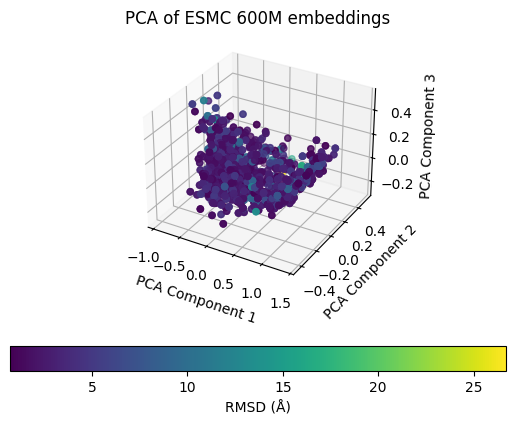

In [110]:
ax = plt.figure().add_subplot(projection="3d")
scatter = ax.scatter(
    embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], c=rmsds
)
# plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.title("PCA of ESMC 600M embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
# add color bar
plt.colorbar(scatter, label="RMSD (Å)", orientation="horizontal")
plt.show()

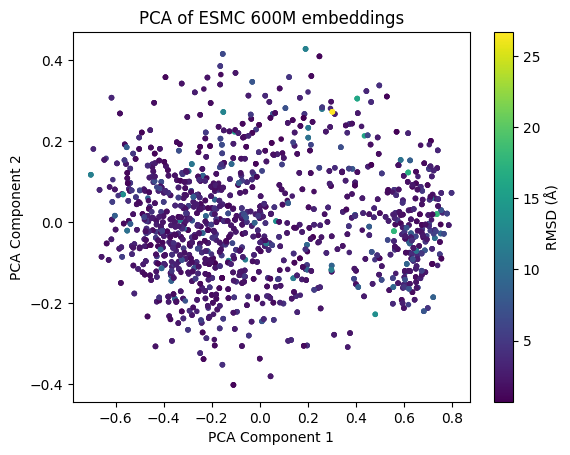

In [116]:
from matplotlib import pyplot as plt

embeddings = np.load(
    "/Users/pablo/software/hackathon-local/esmc_600m-data/embeddings.npy"
)

# normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
# run pca on embeddings
# delete last two rows of embeddings
embeddings = embeddings[:-2]
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=rmsds, marker=".")
# plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.title("PCA of ESMC 600M embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# add color bar
plt.colorbar(label="RMSD (Å)", cmap="coolwarm")
plt.show()


In [127]:
# import residue names
import pandas as pd

residues = []
with open("res_ids.txt", "r") as f:
    for line in f:
        residues.append(line.strip())
residue_id_type, residues = pd.factorize(residues)
print(residue_id_type)
print(residues)
# convert residues to int using pandas
# residues = pd.to_numeric(residues)

[0 0 0 ... 0 0 0]
['V' 'F' 'T' 'K' 'L' 'N' 'I' 'D' 'G' 'C' 'Y' 'A' 'R' 'S' 'M' 'H' 'E' 'W'
 'P' 'Q']


/var/folders/50/gfw3gnc96zx0zr3jngrqlvh00000gn/T/ipykernel_38519/999046641.py:8: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  residue_id_type, residues = pd.factorize(residues)


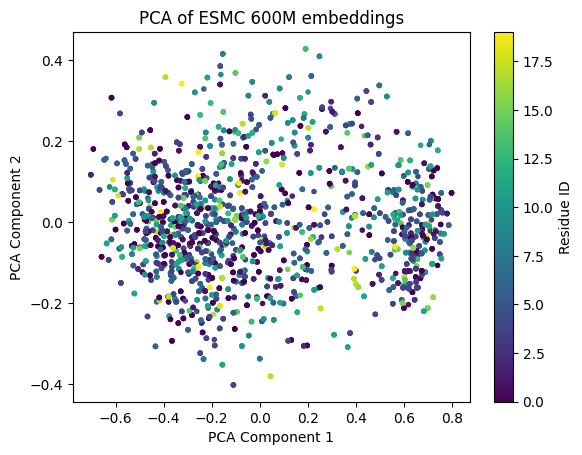

In [128]:
from matplotlib import pyplot as plt


embeddings = np.load(
    "/Users/pablo/software/hackathon-local/esmc_600m-data/embeddings.npy"
)

# normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
# run pca on embeddings
# delete last two rows of embeddings
embeddings = embeddings[:-2]
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)


plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=residue_id_type, marker=".")
# plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.title("PCA of ESMC 600M embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# add color bar
plt.colorbar(label="Residue ID", cmap="coolwarm")
plt.show()


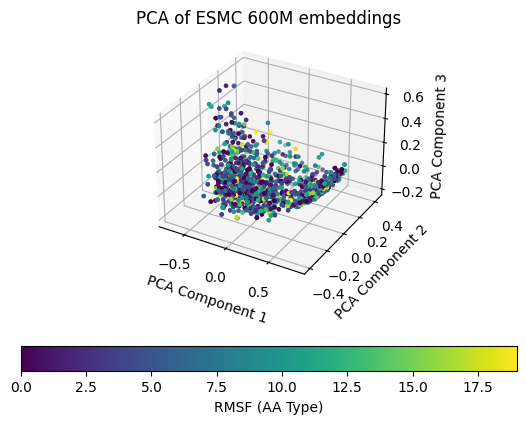

In [132]:
embeddings = np.load(
    "/Users/pablo/software/hackathon-local/esmc_600m-data/embeddings.npy"
)
# normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
# run pca on embeddings
# delete last two rows of embeddings
embeddings = embeddings[:-2]
pca = PCA(n_components=3)
embeddings_pca = pca.fit_transform(embeddings)
ax = plt.figure().add_subplot(projection="3d")
scatter = ax.scatter(
    embeddings_pca[:, 0],
    embeddings_pca[:, 1],
    embeddings_pca[:, 2],
    c=residue_id_type,
    marker=".",
)
# plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.title("PCA of ESMC 600M embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
# add color bar
plt.colorbar(scatter, label="RMSF (AA Type)", orientation="horizontal")
plt.show()

In [95]:
# Overall analysis
embeddings = np.load(
    "/Users/pablo/software/hackathon-local/esmc_300m-data/embeddings.npy"
)
# delete last two rows of embeddings
embeddings = embeddings[:-2]
# run pca on embeddings
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

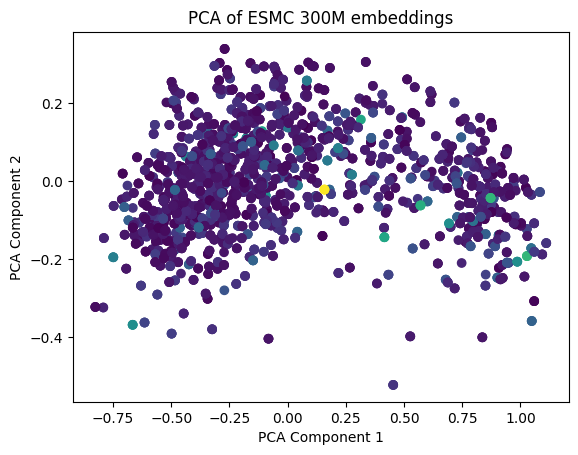

In [96]:
from matplotlib import pyplot as plt

plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=rmsds)
plt.title("PCA of ESMC 300M embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# add color bar
# plt.colorbar(label="RMSD (Å)")
plt.show()


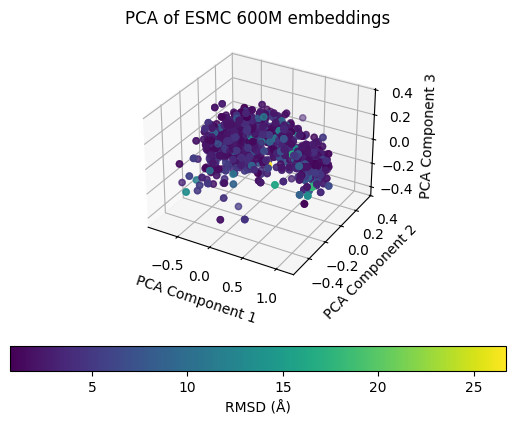

In [111]:
# Overall analysis
embeddings = np.load(
    "/Users/pablo/software/hackathon-local/esmc_300m-data/embeddings.npy"
)
# delete last two rows of embeddings
embeddings = embeddings[:-2]
# run pca on embeddings
pca = PCA(n_components=3)
embeddings_pca = pca.fit_transform(embeddings)
ax = plt.figure().add_subplot(projection="3d")
scatter = ax.scatter(
    embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], c=rmsds
)
# plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.title("PCA of ESMC 600M embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
# add color bar
plt.colorbar(scatter, label="RMSD (Å)", orientation="horizontal")
plt.show()

In [134]:
# lets try umap instead

embeddings = np.load(
    "/Users/pablo/software/hackathon-local/esmc_600m-data/embeddings.npy"
)
# normalize embeddings
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# run umap on embeddings
import umap

umap = umap.UMAP(n_components=2)
embeddings_umap = umap.fit_transform(embeddings)
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=rmsds)
plt.title("UMAP of ESMC 600M embeddings")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.